## MiniPCM

In [1]:
#!pip install flash_attn
# !pip install pillow
#!pip install torch
#!pip install torchvision
# !pip install transformers==4.40.0
# !pip install sentencepiece==0.1.99
# !pip install decord
# #!pip install numpy==1.24.1
# #!conda install cudatoolkit -y
# !pip install hf_transfer

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
# !pip install bitsandbytes
# !pip install accelerate
# !pip install -U flash_attn

In [4]:
# test.py
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

# model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True, device_map="auto")
# tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
# model.eval()

model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6', trust_remote_code=True,
    attn_implementation='sdpa', torch_dtype=torch.bfloat16) # sdpa or flash_attention_2, no eager
model = model.eval().cuda()
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6', trust_remote_code=True)

/miniconda/envs/minicpm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/miniconda/envs/minicpm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/miniconda/envs/minicpm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]
/miniconda/envs

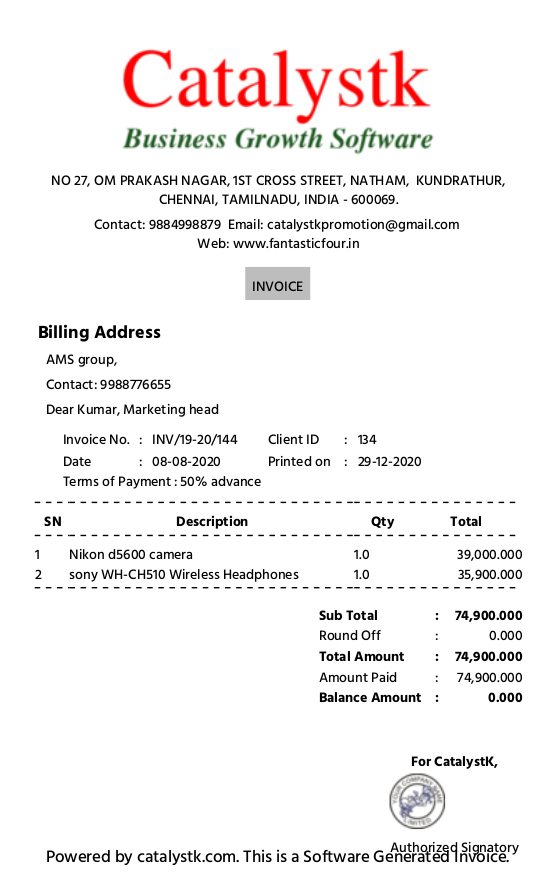

In [5]:
image = Image.open('print_invoice_1.png').convert('RGB')
image

In [6]:
question = 'extract email, phone number and total amount from the image, return response as a well-formed json object?'
msgs = [{'role': 'user', 'content': [image, question]}]

res = model.chat(
    image=None,
    msgs=msgs,
    tokenizer=tokenizer
)
print(res)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{
  "email": "catalystkpromotion@gmail.com",
  "phone number": "+91 9884998879",
  "total amount": "74,900.00"
}


In [7]:
question = 'extract items, quantity and total, return response as a well-formed json object?'
msgs = [{'role': 'user', 'content': [image, question]}]

res = model.chat(
    image=None,
    msgs=msgs,
    tokenizer=tokenizer
)
print(res)

{
  "billingAddress": {
    "company": "AMS group",
    "contactNumber": "9898776655",
    "head": "Dear Kumar, Marketing head"
  },
  "invoiceDetails": {
    "invoiceNo": "INV/19-20/144",
    "clientID": "134",
    "date": "08-08-2020",
    "printedOn": "29-12-2020",
    "termsOfPayment": "50% advance"
  },
  "items": [
    {
      "SN": "1",
      "description": "Nikon d5600 camera",
      "qty": "1.0",
      "total": "39,000.00"
    },
    {
      "SN": "2",
      "description": "Sony WH-CH510 Wireless Headphones",
      "qty": "1.0",
      "total": "35,900.00"
    }
  ],
  "totals": {
    "subTotal": "74,900.00",
    "roundOff": "0.00",
    "totalAmount": "74,900.00",
    "amountPaid": "74,900.00",
    "balanceAmount": "0.00"
  },
  "footer": "Powered by catalystk.com. This is a Software Generated Invoice."
}


### Streaming

In [8]:
## if you want to use streaming, please make sure sampling=True and stream=True
## the model.chat will return a generator
res = model.chat(
    image=None,
    msgs=msgs,
    tokenizer=tokenizer,
    sampling=True,
    stream=True
)

generated_text = ""
for new_text in res:
    generated_text += new_text
    print(new_text, flush=True, end='')

{
  "items": [
    {
      "SN": "1",
      "description": "Nikon d5600 camera",
      "qty": "1.0",
      "total": "39,000.00"
    },
    {
      "SN": "2",
      "description": "sony WH-CH510 Wireless Headphones",
      "qty": "1.0",
      "total": "35,900.00"
    }
  ],
  "sub_total": "74,900.00",
  "round_off": "0.00",
  "total_amount": "74,900.00",
  "amount_paid": "0.00",
  "balance_amount": "0.00"
}

### Chat with multiple images 

In [9]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

# model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6', trust_remote_code=True,
#     attn_implementation='sdpa', torch_dtype=torch.bfloat16) # sdpa or flash_attention_2, no eager
# model = model.eval().cuda()
# tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6', trust_remote_code=True)

image3 = Image.open('receipt_sample3.png').convert('RGB')
image4 = Image.open('receipt_sample4.png').convert('RGB')
question = 'Compare image 3 and image 4, tell me about the differences between image 3 and image 4. and what item is the most expensive one?'

msgs = [{'role': 'user', 'content': [image3, image4, question]}]

answer = model.chat(
    image=None,
    msgs=msgs,
    tokenizer=tokenizer
)
print(answer)


The differences between image 3 and image 4 are as follows:

1. **Date and Time**:
   - Image 3: 24.2.2018, 14:01:53
   - Image 4: 25.11.2017, 18:33:34

2. **Customer Information**:
   - Image 3: User (no specific name)
   - Image 4: John Doe

3. **Order Number**:
   - Image 3: 5
   - Image 4: Not provided in the visible part of the receipt.

4. **Items Ordered**:
   - Image 3: Coca cola (1x 100,00)
   - Image 4: Coca cola (9x $180.00), Pepsi (128x $20.00)

5. **Items Count**:
   - Image 3: 1
   - Image 4: 2 (Coca cola + Pepsi)

6. **Subtotal Amount**:
   - Image 3: 100,00 A
   - Image 4: $1,458.00 A

7. **Total Amount**:
   - Image 3: 100,00 A
   - Image 4: $1,984.00

8. **Paid Amount**:
   - Image 3: 100,00 A
   - Image 4: $1,984.00

9. **Change**:
   - Image 3: 0,00
   - Image 4: $0.00

The most expensive item in either image is "Pepsi" at $20.00 each, with a total cost of $2,510.00 for 128 units in image 4.


### In-context few-shot learning 

In [10]:
# import torch
# from PIL import Image
# from transformers import AutoModel, AutoTokenizer

# # model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6', trust_remote_code=True,
# #     attn_implementation='sdpa', torch_dtype=torch.bfloat16) # sdpa or flash_attention_2, no eager
# # model = model.eval().cuda()
# # tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6', trust_remote_code=True)

# question = "production date" 
# image1 = Image.open('example1.jpg').convert('RGB')
# answer1 = "2023.08.04"
# image2 = Image.open('example2.jpg').convert('RGB')
# answer2 = "2007.04.24"
# image_test = Image.open('test.jpg').convert('RGB')

# msgs = [
#     {'role': 'user', 'content': [image1, question]}, {'role': 'assistant', 'content': [answer1]},
#     {'role': 'user', 'content': [image2, question]}, {'role': 'assistant', 'content': [answer2]},
#     {'role': 'user', 'content': [image_test, question]}
# ]

# answer = model.chat(
#     image=None,
#     msgs=msgs,
#     tokenizer=tokenizer
# )
# print(answer)


## Chat with video

In [11]:
!MP4Box -info 1-STOP-Cleaning-Printer.mp4

# Movie Info - 2 tracks - TimeScale 1000
Duration 00:07:42.472
Fragmented: no
Progressive (moov before mdat)
Major Brand isom - version 512 - compatible brands: isom iso2 mp41
Created: UNKNOWN DATE

iTunes Info:
	tool: Lavf58.76.100

# Track 1 Info - ID 1 - TimeScale 16000
Media Duration 00:07:42.367 
Track has 1 edits: track duration is 00:07:42.368
Track flags: Enabled In Movie
Media Info: Language "Undetermined (und)" - Type "vide:vp09" - 13871 samples
Visual Sample Entry Info: width=640 height=360 (depth=24 bits)
Visual Track layout: x=0 y=0 width=640 height=360
VP9 Video - Resolution 640 x 360
	RFC6381 Codec Parameters: vp09.00.15.08.01.01.01.01.00
	Average GOP length: 152 samples
	Max sample duration: 544 / 16000

# Track 2 Info - ID 2 - TimeScale 44100
Media Duration 00:07:42.471 
Track has 1 edits: track duration is 00:07:42.472
Track flags: Enabled In Movie
Media Info: Language "English (eng)" - Type "soun:mp4a" - 19917 samples
Alternate Group ID 1
MPEG-4 Audio AAC LC (AOT=2 i

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
!MP4Box -info demo_video.mp4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Movie Info - 2 tracks - TimeScale 1000
Duration 00:01:07.708
Fragmented: no
Major Brand isom - version 512 - compatible brands: isom iso2 avc1 mp41
Created: UNKNOWN DATE

iTunes Info:
	tool: Lavf59.27.100

# Track 1 Info - ID 1 - TimeScale 15360
Media Duration 00:01:07.700  (recomputed 00:01:07.766)
Track has 1 edits: track duration is 00:01:07.700
Track flags: Enabled In Movie
Media Info: Language "Undetermined (und)" - Type "vide:avc1" - 2031 samples
Visual Sample Entry Info: width=1920 height=1080 (depth=24 bits)
Visual Track layout: x=0 y=0 width=1920 height=1080
AVC/H264 Video - Visual Size 1920 x 1080
	AVC Info: 1 SPS - 1 PPS - Profile High @ Level 4
	NAL Unit length bits: 32
	Chroma format YUV 4:2:0 - Luma bit depth 8 - chroma bit depth 8
	SPS#1 hash: 626E6535349BB28088B5FA6AD0D61AE6DE22389C
	PPS#1 hash: B1DD26E65362D1B2A6E727AADCD0AA8CCAB0753A
	RFC6381 Codec Parameters: avc1.640028
	Average GOP length: 253 samples
	Max sample duration: 512 / 15360

# Track 2 Info - ID 2 - Tim

In [13]:
#!ffprobe -v error -select_streams v:0 -count_packets -show_entries stream=nb_read_packets -of csv=p=0 1-STOP-Cleaning-Printer.mp4.mp4
#!wget https://github.com/OpenBMB/MiniCPM-V/blob/main/assets/demo_video.mp4

#video_path="1-STOP-Cleaning-Printer.mp4"
video_path="demo_video.mp4"

In [17]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer
from decord import VideoReader, cpu, gpu    # pip install decord

# model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6', trust_remote_code=True,
#     attn_implementation='sdpa', torch_dtype=torch.bfloat16) # sdpa or flash_attention_2, no eager
# model = model.eval().cuda()
# tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6', trust_remote_code=True)

MAX_NUM_FRAMES=13871 # if cuda OOM set a smaller number

def encode_video(video_path):
    def uniform_sample(l, n):
        gap = len(l) / n
        idxs = [int(i * gap + gap / 2) for i in range(n)]
        return [l[i] for i in idxs]

    #vr = VideoReader(video_path, ctx=cpu(0), num_threads=1)
    vr = VideoReader(video_path, ctx=cpu(0), num_threads=1)    
    sample_fps = round(vr.get_avg_fps() / 1)  # FPS
    frame_idx = [i for i in range(0, len(vr), sample_fps)]
    if len(frame_idx) > MAX_NUM_FRAMES:
        frame_idx = uniform_sample(frame_idx, MAX_NUM_FRAMES)
    frames = vr.get_batch(frame_idx).asnumpy()
    frames = [Image.fromarray(v.astype('uint8')) for v in frames]
    print('num frames:', len(frames))
    return frames


In [18]:
#video_path="1-STOP-Cleaning-Printer.mp4"
frames = encode_video(video_path)
question = "Describe the video"
msgs = [
    {'role': 'user', 'content': frames + [question]}, 
]

# Set decode params for video
params={}
params["use_image_id"] = False
params["max_slice_nums"] = 2 #2 # use 1 if cuda OOM and video resolution >  448*448

answer = model.chat(
    image=None,
    msgs=msgs,
    tokenizer=tokenizer,
    **params
)
print(answer)


num frames: 68


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 124 but got size 123 for tensor number 1 in the list.